In [4]:
from __future__ import annotations

import jax
import jax.numpy as jnp
from jax.random import PRNGKey, multivariate_normal
import pyhf
from typing import Callable, Any, Generator, Iterable
from functools import partial
import matplotlib.pyplot as plt
import neos

jax.config.update("jax_enable_x64", True)
pyhf.set_backend("jax")

# matplotlib settings
plt.rc("figure", figsize=(6, 3), dpi=150, facecolor="w")
plt.rc("legend", fontsize=6)

Array = jnp.ndarray

/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


`neos` tackles the problem of learning optimal summary statistics from data. The workflow is explained in more detail [in our paper]() -- this notebook is designed to get you up-and-running with how that workflow looks in code, including how to do this for your own use-case! (if you want to do that for real, please reach out -- we'd love to help you!)

To construct this kind of workflow, you need to specify three things:
- How to construct your summary statistic from data
- How to build your likelihood function from that summary statistic
- A choice of metric relating to how you deem your analysis to be "optimal"

The second bullet in-particular is very important; while we've abstracted away all the technical detail, `neos` is still not a drop-in loss function in the typical sense, since it requires *detailed information from the analyser on how to build the likelihood*. No longer do we have a problem-agnostic notion of "signal" and "background"; instead, we're wanting to optimise our specific problem, so we need to provide specific information. That is how `neos` is "systematic-aware" -- it's a technique that explicitly takes into account how your systematics are modelled. But to do this, we of course need to model them in the first place!

Here, we're going to re-implement the example from the paper with 2-dimensional Gaussian blobs making up our data. We have a nominal estimate for signal and background data, and we also provide "up" and "down" variations that correspond to moving the mean of the background blob. The helper function to generate this dataset is below:

In [5]:
def generate_data(
    rng: int = 0,
    num_points: int = 10000,
    sig_mean: tuple[float, float] = (-1, 1),
    bup_mean: tuple[float, float] = (2.5, 2),
    bdown_mean: tuple[float, float] = (-2.5, -1.5),
    b_mean: tuple[float, float] = (1, -1),
) -> tuple[Array, Array, Array, Array]:
    sig = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(sig_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    bkg_up = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(bup_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    bkg_down = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(bdown_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )

    bkg_nom = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(b_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    return sig, bkg_nom, bkg_up, bkg_down

Now that we have our data, we need to specify how we construct our summary statistic. We will use a neural network for this, left unspecified until later. Since our likelihood modelling stage will later involve using histograms, we'll also construct a histogram of the output, then scale the yields in each batch for a more "realistic" analysis. This step is wrapped up in a simple convenience function called `neos.hists_from_nn`, which we'll use in a moment.

After this comes the problem-specific part: the likelihood model construction. I mentioned before that we have "up" and "down" datasets -- this is a typical construct in HEP that we use to model the effect of physical parameters. We will then have three histograms for the background data: one for each of the nominal, up, and down samples. The HistFactory prescription for building likelihood functions then models the uncertainty between these by interpolating between their yields. Luckily, this is done under the hood for us in `pyhf` -- we just need to write a dictionary specifying the format of our histograms. This can be found below for our case, where we describe our uncertainty by forming a nuisance parameter `"correlated_bkg_uncertainty"` that modifies the shape of the histogram in a bin-correlated fashion. 

In [7]:
# assume we give a dict of histograms with keys "sig", "bkg_nominal", "bkg_up", "bkg_down".
def model_from_hists(hists: dict[str, Array]) -> pyhf.Model:
    """How to make your HistFactory model from your histograms."""
    spec = {
        "channels": [
            {
                "name": "singlechannel",  # we only have one "channel" (data region)
                "samples": [
                    {
                        "name": "signal",
                        "data": hists["sig"],  # signal
                        "modifiers": [
                            {
                                "name": "mu",
                                "type": "normfactor",
                                "data": None,
                            },  # our signal strength modifier (parameter of interest)
                        ],
                    },
                    {
                        "name": "background",
                        "data": hists["bkg_nominal"],  # background
                        "modifiers": [
                            {
                                "name": "correlated_bkg_uncertainty",
                                "type": "histosys",
                                "data": {
                                    "hi_data": hists["bkg_up"],  # up sample
                                    "lo_data": hists["bkg_down"],  # down sample
                                },
                            },
                        ],
                    },
                ],
            },
        ],
    }
    return pyhf.Model(spec, validate=False)

Now we just have to form our metric of choice from our likelihood model. Here, we have a variety to choose from: uncertainty on the signal strength modifier (cross-section), discovery significance, CLs, even the classic binary cross-entropy (that doesn't use the likelihood at all).

In [8]:
def pipeline(
    pars: dict[str, Array],
    data: tuple[Array, ...],
    nn: Callable,
    loss: str | Callable,
    bandwidth: float,
    sample_names: Iterable,
    scale_factors: dict[str, float],
    bins: Array | None = None,  # in case you don't want to optimise binning
) -> float:
    data_dct = {k: v for k, v in zip(sample_names, data)}
    if loss.lower() in ["bce", "binary cross-entropy"]:
        return neos.losses.bce(data=data_dct, pars=pars["nn_pars"], nn=nn)
    hists = neos.hists_from_nn(
        pars=pars,
        nn=nn,
        data=data_dct,
        bandwidth=bandwidth,
        bins=pars["bins"] if "bins" in pars else bins,
        scale_factors=scale_factors,
    )
    model = model_from_hists(hists)
    return neos.loss_from_model(model, loss=loss)

Below is now mostly training boilerplate! I'll add titles, but should be mostly clear what's going on.

### Initialise network architecture + params

In [9]:
from jax.experimental import stax

rng_state = 0  # random state

# feel free to modify :)
init_random_params, nn = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)

num_features = 2
_, init = init_random_params(PRNGKey(rng_state), (-1, num_features))
init_pars = dict(nn_pars=init)

/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


### Define batching mechanism for data

In [12]:
from sklearn.model_selection import train_test_split
import numpy.random as npr

batch_size = 128
data = generate_data(rng=rng_state, num_points=10000)
split = train_test_split(*data, random_state=rng_state)
train, test = split[::2], split[1::2]


def batches(training_data: Array, batch_size: int) -> Generator:
    num_train = training_data[0].shape[0]
    num_complete_batches, leftover = divmod(num_train, batch_size)
    num_batches = num_complete_batches + bool(leftover)

    # batching mechanism
    def data_stream():
        rng = npr.RandomState(rng_state)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size : (i + 1) * batch_size]
                yield [points[batch_idx] for points in train]

    return data_stream()


batch_iterator = batches(train, batch_size)

### Training loop -- change hyperparameters at will!

In [20]:
from jaxopt import OptaxSolver
import optax
from time import perf_counter

include_bins = True
bins = jnp.linspace(0, 1, 5)  # keep in [0,1] if using sigmoid activation
lr = 1e-3
num_steps = 25
# can choose from "CLs", "discovery", "poi_uncert" [approx. uncert. on mu], "bce" [classifier]
objective = "cls"

# the same keys you used in the model building step [model_from_hists]
data_types = ["sig", "bkg_nominal", "bkg_up", "bkg_down"]
scales = {k: 2.0 if k == "sig" else 10.0 for k in data_types}
loss = partial(
    pipeline,
    nn=nn,
    sample_names=data_types,
    scale_factors=scales,
)

solver = OptaxSolver(loss, opt=optax.adam(lr), jit=True)

pyhf.set_backend("jax", default=True)

if include_bins:
    init_pars["bins"] = bins[
        1:-1
    ]  # don't want to float endpoints [will account for kde spill]
    state = solver.init_state(init_pars)
else:
    if "bins" in init_pars:
        del init_pars["bins"]
    state = solver.init_state(init_pars)

params = init_pars
best_params = init_pars
best_sig = 999
metrics = {k: [] for k in ["cls", "discovery", "poi_uncert"]}

for i in range(num_steps):
    print(f"step {i}: loss={objective}")
    data = next(batch_iterator)
    start = perf_counter()
    params, state = solver.update(
        params, state, bins=bins, data=data, loss=objective, bandwidth=9e-2
    )
    end = perf_counter()
    print(f"update took {end-start:.4g}s")
    if "bins" in params:
        print("bin edges: [", *[f"{f:.3g}" for f in params["bins"]], "]")
    for metric in metrics:
        test_metric = loss(params, bins=bins, data=test, loss=metric, bandwidth=1e-8)
        print(f"{metric}={test_metric:.4g}")
        metrics[metric].append(test_metric)
    if metrics["discovery"][-1] < best_sig:
        best_params = params
        best_sig = metrics["discovery"][-1]
    print()

step 0: loss=neos


/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


update took 2.458s
bin edges: [ 0.251 0.499 0.749 ]
cls=0.2014
discovery=0.2395
poi_uncert=1.334

step 1: loss=neos
update took 1.986s
bin edges: [ 0.252 0.498 0.748 ]
cls=0.1374
discovery=0.1896
poi_uncert=0.8948

step 2: loss=neos
update took 1.973s
bin edges: [ 0.253 0.498 0.747 ]
cls=0.1232
discovery=0.1833
poi_uncert=0.8561

step 3: loss=neos
update took 2.015s
bin edges: [ 0.253 0.497 0.746 ]
cls=0.12
discovery=0.1849
poi_uncert=0.8348

step 4: loss=neos
update took 1.98s
bin edges: [ 0.254 0.496 0.746 ]
cls=0.1239
discovery=0.2048
poi_uncert=0.9215

step 5: loss=neos
update took 1.992s
bin edges: [ 0.255 0.496 0.745 ]
cls=0.1244
discovery=0.2074
poi_uncert=0.9528

step 6: loss=neos
update took 1.975s
bin edges: [ 0.255 0.495 0.744 ]
cls=0.1218
discovery=0.1982
poi_uncert=0.9223

step 7: loss=neos
update took 2.06s
bin edges: [ 0.255 0.495 0.743 ]
cls=0.1196
discovery=0.1868
poi_uncert=0.8645

step 8: loss=neos
update took 2.491s
bin edges: [ 0.256 0.494 0.742 ]
cls=0.1155
discov

## Random visualisations!

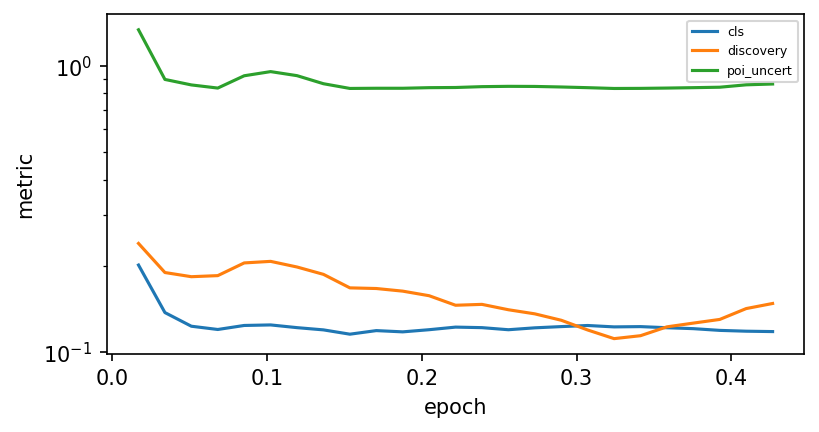

In [24]:
import matplotlib.pyplot as plt

epoch_grid = (jnp.array(list(range(1, num_steps + 1))) * batch_size) / train[0].shape[0]
for k, v in metrics.items():
    if k != "generalised_variance":
        plt.plot(epoch_grid, v, label=k)
plt.yscale("log")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("metric")
plt.savefig("float.png")

In [25]:
yields = neos.hists_from_pars(
    best_params["nn_pars"],
    {k: v for k, v in zip(data_types, test)},
    nn,
    bandwidth=1e-8,
    scale_factors={k: 2.0 if k == "sig" else 10.0 for k in data_types},
    bins=best_params["bins"],
)

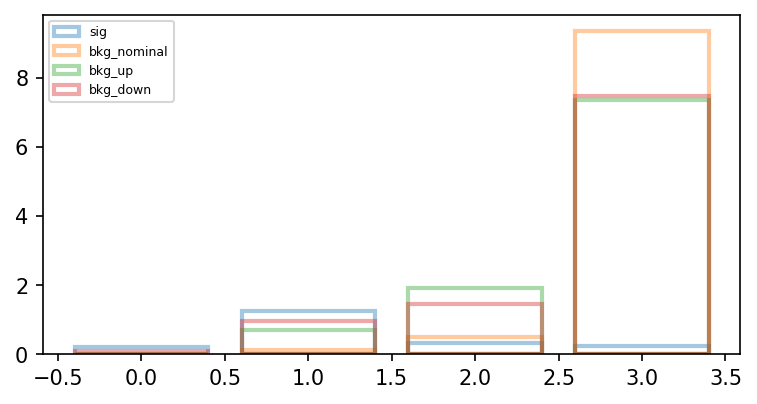

In [26]:
for c, (l, a) in zip(
    ["C0", "C1", "C2", "C3"], zip(yields, jnp.array(list(yields.values())))
):
    plt.bar(range(len(a)), a, label=l, alpha=0.4, fill=None, edgecolor=c, linewidth=2)
plt.legend()

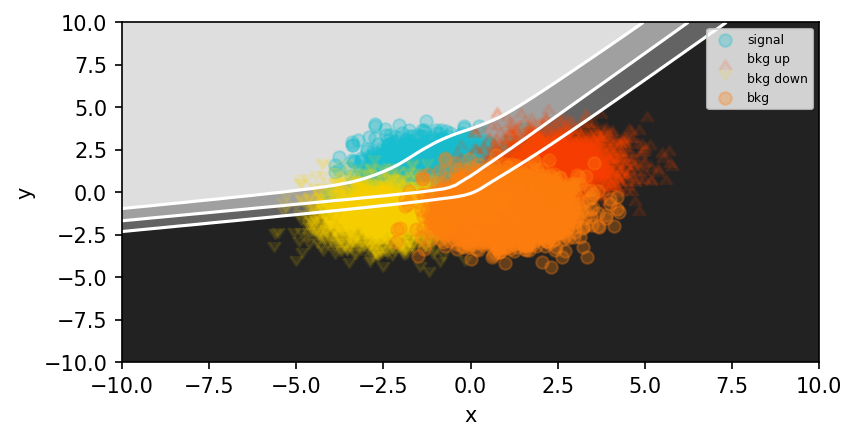

In [28]:
def plot_data_space(
    ax: Any,
    params: dict[str, Any],
    data: Array,
    nn: Callable,
    bins: Array | None = None,
) -> None:
    network = params["nn_pars"]
    bins = params["bins"] if "bins" in params else bins
    g = jnp.mgrid[-10:10:101j, -10:10:101j]
    levels = [0, *bins, 1]
    ax.contourf(
        g[0],
        g[1],
        nn(network, jnp.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        levels=levels,
        cmap="binary",
    )
    ax.contour(
        g[0],
        g[1],
        nn(network, jnp.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        colors="w",
        levels=levels,
    )
    sig, bkg_nom, bkg_up, bkg_down = data
    # should definitely not have to repeat this every time lmao
    ax.scatter(sig[:, 0], sig[:, 1], alpha=0.3, c="C9", label="signal")
    ax.scatter(
        bkg_up[:, 0],
        bkg_up[:, 1],
        alpha=0.1,
        c="orangered",
        marker=6,
        label="bkg up",
    )
    ax.scatter(
        bkg_down[:, 0],
        bkg_down[:, 1],
        alpha=0.1,
        c="gold",
        marker=7,
        label="bkg down",
    )
    ax.scatter(bkg_nom[:, 0], bkg_nom[:, 1], alpha=0.3, c="C1", label="bkg")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()


fig, ax = plt.subplots()
plot_data_space(ax, best_params, data=test, nn=nn)